In [2]:
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math as math

In [3]:
"""
Plot styling
"""
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [8, 6]

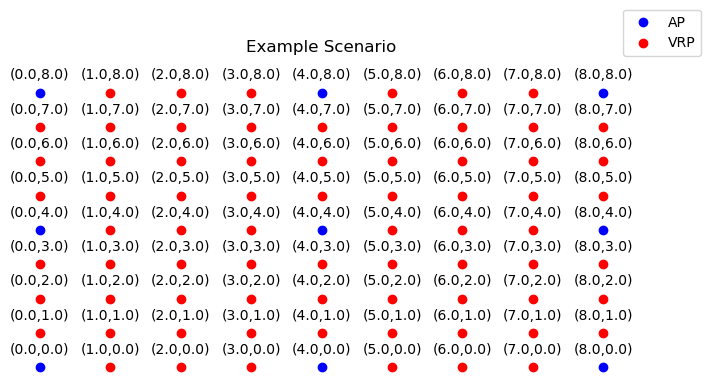

In [42]:
"""
Locations plot
"""
locations = np.array(np.meshgrid(np.linspace(0, 8, 9), np.linspace(0, 8, 9))).T.reshape(-1, 2)

L_ap = locations[[0,4,8,36,40,44,72,76,80], :]
L_vrp = np.delete(locations, [0,4,8,36,40,44,72,76,80], 0)

plt.figure(figsize=(8,4))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Example Scenario',pad=20)
plt.axis('off')

for x,y in zip(locations[:,0],locations[:,1]):

    label = f"({x},{y})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [5]:
"""
Compute Euclidean distance vector
    
    target --> Reference AP location to calculate distance
    array --> Array of AP/VRP locations
"""
def compute_euclidean_distance_vector(target, array):
    d_vec = np.array([np.linalg.norm(target - i) for (i) in array])
    return d_vec

In [6]:
"""
Polynomial Surface model fitting
    
    locations --> X,Y tuple array of AP locations
    d --> AP RTT distance observations
    order --> Polinomial order
"""
def surface_fit(locations, d, order=1):
    if order == 1:
        A = np.c_[locations[:,0], locations[:,1], np.ones(locations.shape[0])]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    else:
        A = np.c_[np.ones(locations.shape[0]), locations[:,:2], np.prod(locations[:,:2], axis=1), locations[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    return C

In [7]:
"""
RTT distance estimation
    
    x --> AP's x locations
    y --> AP's y locations
    C --> Model coefficients
"""
def sample_distance(x, y, C):
    
    XX = x.flatten()
    YY = y.flatten()
    
    if C.shape[0] == 3:
        fit = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(x.shape)
    else:
        fit = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(x.shape)
    return fit

In [8]:
# ----------------------------------------------------------------------
#  AP RTT distance observations
ap_loc = locations[0]

# Let's assume an euclidean distance as RTT distance observations
d_RTT = compute_euclidean_distance_vector(ap_loc, locations)

In [9]:
"""
Surface fitting values
"""

# Plot domain
X,Y = np.meshgrid(np.arange(0.0, 8.0, 0.5), np.arange(0.0, 8.0, 0.5))

#Model fitting and surface estimation
model_1 = surface_fit(locations, d_RTT)
model_2 = surface_fit(locations, d_RTT, 2)

Z_1 = sample_distance(X, Y, model_1)
Z_2 = sample_distance(X, Y, model_2)

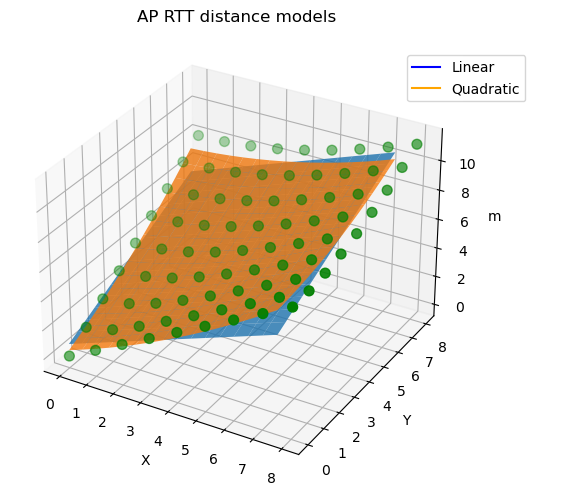

In [10]:
"""
Surface fitting plot
"""
fig = plt.figure()

ax = fig.gca(projection='3d')

l1 = ax.plot_surface(X, Y, Z_1, rstride=1, cstride=1, alpha=0.8, label='linear')
l2 = ax.plot_surface(X, Y, Z_2, rstride=1, cstride=1, alpha=0.8, label='quadratic')

ax.scatter(locations[:,0], locations[:,1], d_RTT, c='g', s=50)

plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('m')
ax.axis('auto')

line_labels = ["Linear", "Quadratic"]

ax.plot([0], [0], color="blue")[0]
ax.plot([0], [0], color="orange")[0]

fig.legend(labels= line_labels,loc="upper right",borderaxespad=4)

plt.title('AP RTT distance models')
plt.show()

In [11]:
test = sample_distance(np.array([0,0,0]), np.array([0,4,8]), model_1)
print('Linear model:\n','Locations: [0,0][0,4][0,8]','Samples:',test,'Observations:',d_RTT[0:3])

test = sample_distance(np.array([0,0,0]), np.array([0,4,8]), model_2)
print('Quadratic model:\n','Locations: [0,0][0,4][0,8]','Samples:',test,'Observations:',d_RTT[0:3])

Linear model:
 Locations: [0,0][0,4][0,8] Samples: [0.84585457 3.54171824 6.2375819 ] Observations: [0. 1. 2.]
Quadratic model:
 Locations: [0,0][0,4][0,8] Samples: [0.41327208 3.64793032 8.15713353] Observations: [0. 1. 2.]


In [12]:
print("Distance",math.sqrt(32))
test = sample_distance(np.array(4), np.array(4), model_1)
print("Linear fitting", test)
test = sample_distance(np.array(4), np.array(4), model_2)
print("Quadratic fitting", test)

Distance 5.656854249492381
Linear fitting 6.237581900215436
Quadratic fitting 5.706521491365178
